In [1]:
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline
# import color maps
from matplotlib.colors import ListedColormap

# Seaborn for easier visualization
import seaborn as sns

In [2]:
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.shape

(35887, 3)

<Axes: xlabel='emotion', ylabel='count'>

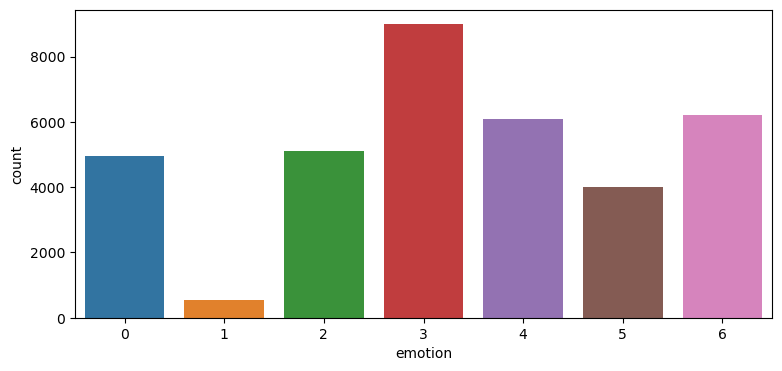

In [4]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [5]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

<Axes: xlabel='Usage', ylabel='count'>

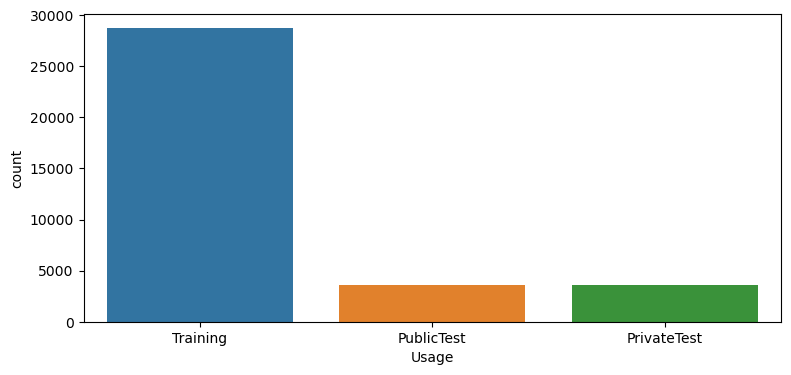

In [6]:
plt.figure(figsize=(9,4))
sns.countplot(x='Usage', data=df)

## PreProcessing

In [7]:
import cv2
image_size=(48,48)
pixels = df['pixels'].tolist() # Converting the relevant column element into a list for each row
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')] # Splitting the string by space character as a list
  face = np.asarray(face).reshape(width, height) #converting the list to numpy array in size of 48*48
  face = cv2.resize(face.astype('uint8'),image_size) #resize the image to have 48 cols (width) and 48 rows (height)
  faces.append(face.astype('float32')) #makes the list of each images of 48*48 and their pixels in numpyarray form
  
faces = np.asarray(faces) #converting the list into numpy array
faces = np.expand_dims(faces, -1) #Expand the shape of an array -1=last dimension => means color space
emotions = pd.get_dummies(df['emotion']).to_numpy() #doing the one hot encoding type on emotions

In [8]:
print(faces.shape)
print(faces[0].ndim)
print(type(faces))

(35887, 48, 48, 1)
3
<class 'numpy.ndarray'>


## Splitting the dataset

In [9]:
x = faces.astype('float32')
x = x / 255.0 #Dividing the pixels by 255 for normalization  => range(0,1)

# Scaling the pixels value in range(-1,1)
x = x - 0.5
x = x * 2.0

In [10]:
num_samples, num_classes = emotions.shape

num_samples = len(x)
num_train_samples = int((1 - 0.2)*num_samples)

# Traning data
train_x = x[:num_train_samples]
train_y = emotions[:num_train_samples]

# Validation data
val_x = x[num_train_samples:]
val_y = emotions[num_train_samples:]

train_data = (train_x, train_y)
val_data = (val_x, val_y)

In [11]:
print('Training Pixels',train_x.shape)  # ==> 4 dims -  no of images , width , height , color
print('Training labels',train_y.shape)

print('Validation Pixels',val_x.shape)
print('Validation labels',val_y.shape)

Training Pixels (28709, 48, 48, 1)
Training labels (28709, 7)
Validation Pixels (7178, 48, 48, 1)
Validation labels (7178, 7)


## Importing oneDNN

In [ ]:
import oneDNN as dnn

In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

## Model Definition

In [12]:
#load the libaray to built the model
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

In [13]:
input_shape=(48, 48, 1)
num_classes = 7
model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                            name='image_array', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(.5))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))



model.add(BatchNormalization())
model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax',name='predictions'))


In [14]:
# parameters
batch_size = 32 #Number of samples per gradient update
num_epochs = 200 # Number of epochs to train the model.
verbose = 1 #per epohs  progress bar
num_classes = 7 
patience = 50
base_path = 'mod/'

In [15]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [16]:
# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 16)        64        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d (Average  (None, 24, 24, 16)        0

In [ ]:
datasets = ['fer2013']
num_epochs = 30
base_path="/content"
for dataset_name in datasets:
    print('Training dataset:', dataset_name)

    #callbacks
    log_file_path = dataset_name + '_emotion_training.log'

    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_loss', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,patience=int(patience/4), verbose=1)
    
    trained_models_path = base_path + dataset_name + 'simple_cnn'
    model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}.hdf5'      # if error "acc" in 1 line ... don't confuse check entire block since fit() generates a inner loop
    model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
    my_callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

    # loading dataset
    train_faces, train_emotions = train_data
    history=model.fit_generator(data_generator.flow(train_faces, train_emotions,
                                            batch_size),
                        epochs=num_epochs, verbose=1
                        ,callbacks=my_callbacks,validation_data =val_data)   #not callbacks = [my_callbacks] since we my_callbacks is already a list 

In [ ]:
model.save_weights("model.h5")
model.load_weights("model.h5")

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")

In [ ]:
""" loading the model in modular approach """

def load_model_():
  json_file = open('model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights("model.h5")
  return model


model = load_model_()